In [1]:
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 13.5MB/s 


In [3]:
import sentencepiece as spm
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

# 감정분석 데이터 전처리

In [4]:
path = "/content/drive/MyDrive/네이버 영화 분류/"

In [5]:
vocab_file = path + "kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [6]:
""" train data 준비 """
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

prepare_train(vocab, path + 'ratings_train.txt', path + 'ratings_train.json')
prepare_train(vocab, path + 'ratings_test.txt', path + 'ratings_test.json')

# Transformer Example

In [7]:
import torch
from torch import nn

### ex)

In [8]:
# Example
lines = ["벌써 여름인가 봐요.", "카페에 에어컨이 강하네요."]

inputs = []
for l in lines:
  pieces = vocab.encode_as_pieces(l)
  ids = vocab.encode_as_ids(l)
  inputs.append(torch.tensor(ids))

# 최대 길이에 맞게 padding(0) 추가
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first= True, padding_value= 0)
print(inputs)

tensor([[ 810, 4096, 2345, 3619, 3599, 3587, 4805, 3760, 3590,    0,    0,    0],
        [ 210, 3896, 3591,  180, 3624, 4253, 3588,  138, 3596, 3857, 3760, 3590]])


In [9]:
print(pieces)

['▁카', '페', '에', '▁에', '어', '컨', '이', '▁강', '하', '네', '요', '.']


In [10]:
inputs.size()

torch.Size([2, 12])

## 1. Input Embedding

In [11]:
n_vocab = len(vocab)
d_hidn = 128
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
input_embs.size()

torch.Size([2, 12, 128])

## 2. Position Embedding
- position encoding  
  1) 각 position별 angle 값을 구함  
  2) 구해진 angle 중 짝수 idx 값에 대한 sin값  
  3) 구해진 angle 중 홀수 idx 값에 대한 cos값

In [12]:
# 삼각비 position embedding
def get_sinusoid_encoding_table(seq, hidn):
  def cal_angle(p, i):
    return p / np.power(10000, 2 * (i // 2) / hidn)
  
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(hidn)]

  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(seq)])
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # 짝수 sin
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # 홀수 cos
  
  return sinusoid_table

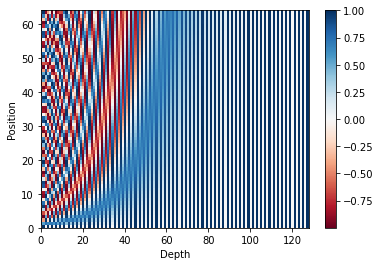

In [13]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

- position embedding  
  1) encoding 값으로 embedding 생성, 학습된게 아니기 때문에 fress = True  
  2) `inputs`와 같은 크기의 `positions`값 구함  
  3) input값 중 pad(0) 찾아 동일 위치의 position을 0으로 변경  
  4) `positions`에 해당하는 embedding값을 구함

In [14]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze = True)

positions = torch.arange(inputs.size(1), device = inputs.device, dtype = inputs.dtype)\
                .expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions)

In [15]:
inputs, positions

(tensor([[ 810, 4096, 2345, 3619, 3599, 3587, 4805, 3760, 3590,    0,    0,    0],
         [ 210, 3896, 3591,  180, 3624, 4253, 3588,  138, 3596, 3857, 3760, 3590]]),
 tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  0,  0],
         [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]]))

In [16]:
pos_embs.size()

torch.Size([2, 12, 128])

In [17]:
final_input = input_embs + pos_embs
final_input

tensor([[[ 1.9586e+00,  7.4693e-01,  2.0579e-01,  ...,  1.1429e+00,
           7.3423e-02,  2.4807e-01],
         [ 1.0617e+00,  2.7043e-01,  1.0299e+00,  ...,  4.9614e-01,
           1.9396e+00,  8.7922e-01],
         [ 6.9829e-02,  2.1029e-01, -3.2022e-01,  ...,  7.9172e-01,
           2.0979e+00, -7.2564e-01],
         ...,
         [ 1.9241e+00, -5.9047e-01,  2.9433e-01,  ...,  2.8012e+00,
           7.2918e-01,  7.0781e-01],
         [ 1.9241e+00, -5.9047e-01,  2.9433e-01,  ...,  2.8012e+00,
           7.2918e-01,  7.0781e-01],
         [ 1.9241e+00, -5.9047e-01,  2.9433e-01,  ...,  2.8012e+00,
           7.2918e-01,  7.0781e-01]],

        [[ 1.8647e+00,  5.6728e-03, -1.7053e-01,  ...,  1.9652e+00,
          -8.8622e-01,  2.8205e+00],
         [ 1.4961e+00, -1.3201e+00,  1.3008e-01,  ...,  2.1662e+00,
           9.4436e-01,  1.9966e+00],
         [-6.3606e-01, -1.8103e+00,  1.3700e+00,  ...,  4.3023e-01,
          -3.4414e-01,  9.2789e-01],
         ...,
         [ 8.6933e-02, -1

## 3. Scaled Dot Product Attention
- Q(query), K(key), V(value)
1. MatMul $QK^T$
2. Scale $\sqrt{d_k}$
3. Mask
4. SoftMax $softmax()$
5. MatMul $V$

### ex)

In [18]:
Q, K, V = final_input, final_input, final_input

# pad(0) 부분만 True
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
attn_mask.size()

torch.Size([2, 12, 12])

In [19]:
attn_mask[0]

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  

In [20]:
# 1. MatMul
scores = torch.matmul(Q, K.transpose(-1, -2))
scores.size()

torch.Size([2, 12, 12])

In [21]:
scores[0] # 각 단어 상호간 가중치를 표현하는 테이블

tensor([[183.8857,  66.9244,  42.7971,  56.8180,  25.1052,  43.6283,  42.3348,
          21.8506,  50.3958,  24.5865,  24.5865,  24.5865],
        [ 66.9244, 184.6948,  60.0312,  77.4746,  68.9651,  56.6888,  53.0544,
          80.7915,  51.9832,  36.5486,  36.5486,  36.5486],
        [ 42.7971,  60.0312, 190.8588,  94.0842,  82.2619,  58.3160,  75.7481,
          71.4645,  56.9740,  62.9753,  62.9753,  62.9753],
        [ 56.8180,  77.4746,  94.0842, 198.5822,  78.8167,  62.9366,  50.9463,
          84.8648,  51.2360,  37.0179,  37.0179,  37.0179],
        [ 25.1052,  68.9651,  82.2619,  78.8167, 201.9295,  63.3768,  77.0248,
          78.1360,  58.5075,  63.3509,  63.3509,  63.3509],
        [ 43.6283,  56.6888,  58.3160,  62.9366,  63.3768, 169.5007,  68.2914,
          54.5833,  56.5533,  44.3167,  44.3167,  44.3167],
        [ 42.3348,  53.0544,  75.7481,  50.9463,  77.0248,  68.2914, 161.3154,
          44.3676,  56.1323,  39.6563,  39.6563,  39.6563],
        [ 21.8506,  80.7915

In [22]:
# 2. Scale
d_head = 64
scores = scores.mul_(1/d_head**0.5)
scores.size()

torch.Size([2, 12, 12])

In [23]:
scores[0] # 가중치 편차 감소

tensor([[22.9857,  8.3656,  5.3496,  7.1023,  3.1381,  5.4535,  5.2918,  2.7313,
          6.2995,  3.0733,  3.0733,  3.0733],
        [ 8.3656, 23.0868,  7.5039,  9.6843,  8.6206,  7.0861,  6.6318, 10.0989,
          6.4979,  4.5686,  4.5686,  4.5686],
        [ 5.3496,  7.5039, 23.8573, 11.7605, 10.2827,  7.2895,  9.4685,  8.9331,
          7.1217,  7.8719,  7.8719,  7.8719],
        [ 7.1023,  9.6843, 11.7605, 24.8228,  9.8521,  7.8671,  6.3683, 10.6081,
          6.4045,  4.6272,  4.6272,  4.6272],
        [ 3.1381,  8.6206, 10.2827,  9.8521, 25.2412,  7.9221,  9.6281,  9.7670,
          7.3134,  7.9189,  7.9189,  7.9189],
        [ 5.4535,  7.0861,  7.2895,  7.8671,  7.9221, 21.1876,  8.5364,  6.8229,
          7.0692,  5.5396,  5.5396,  5.5396],
        [ 5.2918,  6.6318,  9.4685,  6.3683,  9.6281,  8.5364, 20.1644,  5.5460,
          7.0165,  4.9570,  4.9570,  4.9570],
        [ 2.7313, 10.0989,  8.9331, 10.6081,  9.7670,  6.8229,  5.5460, 25.6577,
          8.7715,  4.2752,  4.

In [24]:
# 3. Mask
scores.masked_fill_(attn_mask, -1e9)
scores.size()

torch.Size([2, 12, 12])

In [25]:
scores[0] # 아주 작은 값으로 mask됨

tensor([[ 2.2986e+01,  8.3656e+00,  5.3496e+00,  7.1023e+00,  3.1381e+00,
          5.4535e+00,  5.2918e+00,  2.7313e+00,  6.2995e+00, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 8.3656e+00,  2.3087e+01,  7.5039e+00,  9.6843e+00,  8.6206e+00,
          7.0861e+00,  6.6318e+00,  1.0099e+01,  6.4979e+00, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 5.3496e+00,  7.5039e+00,  2.3857e+01,  1.1761e+01,  1.0283e+01,
          7.2895e+00,  9.4685e+00,  8.9331e+00,  7.1217e+00, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 7.1023e+00,  9.6843e+00,  1.1761e+01,  2.4823e+01,  9.8521e+00,
          7.8671e+00,  6.3683e+00,  1.0608e+01,  6.4045e+00, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 3.1381e+00,  8.6206e+00,  1.0283e+01,  9.8521e+00,  2.5241e+01,
          7.9221e+00,  9.6281e+00,  9.7670e+00,  7.3134e+00, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 5.4535e+00,  7.0861e+00,  7.2895e+00,  7.8671e+00,  7.9221e+00,
      

In [26]:
# 4. Softmax
attn_prob = nn.Softmax(dim = -1)(scores)
attn_prob.size()

torch.Size([2, 12, 12])

In [27]:
attn_prob[0] # 가중치 확률로 변환, mask는 모두 0

tensor([[1.0000e+00, 4.4725e-07, 2.1916e-08, 1.2645e-07, 2.4006e-09, 2.4315e-08,
         2.0685e-08, 1.5982e-09, 5.6658e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0422e-07, 9.9999e-01, 1.7077e-07, 1.5113e-06, 5.2168e-07, 1.1245e-07,
         7.1394e-08, 2.2878e-06, 6.2447e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.1664e-09, 7.9029e-08, 9.9999e-01, 5.5772e-06, 1.2724e-06, 6.3778e-08,
         5.6364e-07, 3.2996e-07, 5.3929e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0141e-08, 2.6635e-07, 2.1239e-06, 1.0000e+00, 3.1500e-07, 4.3274e-08,
         9.6675e-09, 6.7087e-07, 1.0024e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.5163e-10, 6.0504e-08, 3.1888e-07, 2.0730e-07, 1.0000e+00, 3.0089e-08,
         1.6570e-07, 1.9039e-07, 1.6371e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4682e-07, 7.5126e-07, 9.2072e-07, 1.6405e-06, 1.7333e-06, 9.9999e-01,
         3.2038e-06, 5.7742e-07, 7.3865e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.4745e-07, 1

In [28]:
# 5. Matmul
context = torch.matmul(attn_prob, V)
context.size()

torch.Size([2, 12, 128])

In [29]:
Q.size()

torch.Size([2, 12, 128])

### Class화

In [30]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## 4. Multi-Head Attention
- ScaledDotProductAttention과 Q, K, V 같음
- head 2개
- head dimension 64

### ex)

In [31]:
Q, K, V = final_input, final_input, final_input

# pad(0) 부분만 True
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

1. Q를 여러 개의 head로 나누기 $QW_i^Q, KW_i^K, VW_i^V$
2. Attention $Attention() = head_i$
3. Concat $Concat(head_1, head_2, ... , head_h)$
4. Linear $W^O$

In [32]:
# 1. Q를 여러개의 head로
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 12, 64]) torch.Size([2, 2, 12, 64]) torch.Size([2, 2, 12, 64])


In [33]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 12, 12])
torch.Size([2, 2, 12, 12])


In [34]:
# 2. Attention
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)

In [35]:
context.size(), attn_prob.size()

(torch.Size([2, 2, 12, 64]), torch.Size([2, 2, 12, 12]))

In [36]:
# 3. Concat
context = context.transpose(1, 2).contiguous()\
                 .view(batch_size, -1, n_head * d_head)
context.size() # Multi-Head 합체

torch.Size([2, 12, 128])

In [37]:
# 4. Linear
linear = nn.Linear(n_head * d_head, d_hidn)

output = linear(context)
output.size()

torch.Size([2, 12, 128])

In [38]:
Q.size() # 같은 shape의 Multi-Head Attention

torch.Size([2, 12, 128])

### Class화

In [39]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## 5. Masked Multi-Head Attention
- attention mask를 제외하고 Multi-Head와 같음

### ex)

In [40]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
attn_dec_mask = get_attn_decoder_mask(inputs)
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0) # 합체

batch_size = Q.size(0)
n_head = 2

In [41]:
attn_pad_mask[1]

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, F

In [42]:
attn_dec_mask[1]

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [43]:
attn_mask[1]

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, F

In [44]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)

In [45]:
output.size(), attn_prob.size()

(torch.Size([2, 12, 128]), torch.Size([2, 2, 12, 12]))

## 6. FeedForward

$FFN(x) = max(0, xW_1, b_1)W_2 + b_2$

1. f1 $xW_1 + b_1$
2. Activation $max(0, f_1)$
3. f3 $max(0, xW_1, b_1)W_2 + b_2$


### ex)

In [46]:
# 1. f1
conv1 = nn.Conv1d(in_channels = d_hidn, out_channels = d_hidn * 4, kernel_size = 1)

ff_1 = conv1(output.transpose(1, 2))
ff_1.size() # 4배의 hidden dimension

torch.Size([2, 512, 12])

In [47]:
# 2. Activation (relu, gelu)
active = nn.functional.gelu
ff_2 = active(ff_1)

In [48]:
# 3. f3
conv2 = nn.Conv1d(in_channels = d_hidn * 4, out_channels = d_hidn, kernel_size = 1)
ff_3 = conv2(ff_2).transpose(1, 2)
ff_3.size()

torch.Size([2, 12, 128])

### Class화

In [49]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

# Transformer Class화

### Config

In [50]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [51]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


### Attention Pad Mask
1. K의 값 중 pad 부분을 True로 
2. 구해진 값의 크기를 Q-len, K-len 되도록 변경

In [52]:
""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

### Attention Decoder Mask
1. 모든 값이 1인 Q-len, K-len 테이블 생성
2. 대각선을 기준으로 아래쪽을 0으로

In [53]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

### Scaled Dot Product Attention
1. Q * K.transpose
2. K-dimension에 루트에 취함
3. Mask 적용
4. Softmax로 각 단어의 가중치 확률분포 attn_prob
5. attn_prob * V

In [54]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

### Multi-Head Attention
1. Q * W_Q를 한 후 multi-head로 나누기
2. K * W_K를 한 후 multi-head로 나누기
3. V * W_V를 한 후 multi-head로 나누기
4. ScaledDotProductAttention 클래스를 이용해 각 head별 Attention을 구함
5. 여러 개의 head를 1개로 합침
6. Linear를 취해 최종 Multi-Head Attention값을 구함 

In [55]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

### FeedForward
1. Linear, shape을 d_ff(hidden * 4) 키우기
2. activation(relu, gelu) 실행
3. Linear로 shape을 hidden크기로 줄이기

In [56]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = nn.functional.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2))
        output = self.active(output)
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

## Encoder 
- layer
  1. Multi-Head Attention 수행 (Q=K=V self-attention)
  2. input(residual) 더해서 LayerNorm
  3. Feed Forward
  4. 2번 + 3번 더해서 LayerNorm
  

In [57]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        # multi-head attention
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        # LayerNorm
        att_outputs = self.layer_norm1(inputs + att_outputs)
        
        # (bs, n_enc_seq, d_hidn)
        # Feed Forward
        ffn_outputs = self.pos_ffn(att_outputs)
        # LayerNorm
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

In [58]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        # position 구하기
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        # input_embs + pos_embs
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        # attention pad mask 구하기
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            # 각 layer를 연결하여 실행
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

## Decoder
- layer
  1. Multi-Head Attention (self-attention)
  2. input(residual) 더해서 LayerNorm
  3. Encoder-Decoder Multi-Head attention 수행  
    Q: Input LayerNorm  
    K, V: Encoder 결과  
  4. 2번 + 3번 더해서 LayerNorm
  5. Feed Forward
  6. 4번 + 5번 더해서 LayerNorm
    

In [59]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [60]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

## Transformer

In [61]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# 네이버 영화 감정분석 분류

In [62]:
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

In [63]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

In [64]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

In [65]:
batch_size = 128
train_dataset = MovieDataSet(vocab, path + "ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, path + "ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading /content/drive/MyDrive/네이버 영화 분류/ratings_train.json: 100%|██████████| 149995/149995 [00:05<00:00, 28245.76 lines/s]
Loading /content/drive/MyDrive/네이버 영화 분류/ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 29462.45 lines/s]


In [66]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

In [67]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [68]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2 # 긍정, 부정
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


In [69]:
''' 모델 평가 '''
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

Valid: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s, Acc: 0.830]


,loss,score
0,0.483795,0.798868
1,0.402647,0.813749
2,0.377335,0.822669
3,0.354886,0.826090
4,0.334256,0.829570
5,0.312750,0.831370
6,0.290962,0.832590
7,0.270384,0.834210
8,0.246553,0.834310
9,0.223530,0.829650


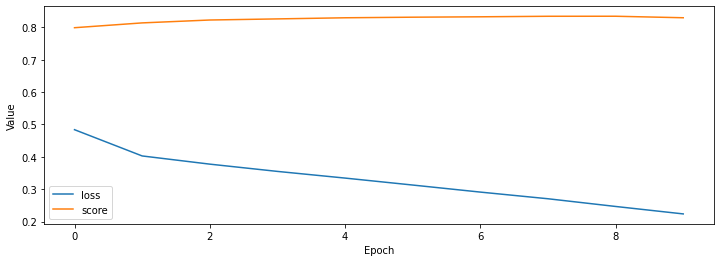

In [70]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()